In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import scipy.io
from lab8_common import *
from Display_Animation import display_animation
import pdb

%matplotlib inline

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load Data

In [2]:
sensor_data_mat = scipy.io.loadmat('lib/sensors.mat')
data = sensor_data_mat['sonars']
true_states = sensor_data_mat['true_states']

In [3]:
true_states.shape

(3, 225)

In [4]:
data.shape

(11, 225)

# Define Partical Filter

In [76]:
class Partical_Filter:
    def __init__(self, data, true_states):
        self.data = data
        self.true_states = true_states
        self.room_map = create_map()
        self.verbose = True

        self.S = 2000
        self.Smin = self.S * 0.99
        self.dynamics_mean = np.zeros(3)
        self.dynamics_sigma = np.asarray([[0.0005, 0.0, 0.0],
                                         [0.0, 0.0005, 0.0],
                                         [0.0, 0.0, 0.1 * 2 * np.pi]])
        
        self.particles = []
        #  set up uniform prior distribution
        x_uniform_random = [np.random.random() for i in range(self.S)]
        y_uniform_random = [np.random.random() for i in range(self.S)]
        theta_uniform_random = [np.random.random() * 2 * np.pi for i in range(self.S)]
        self.particles.append(np.asarray([x_uniform_random, y_uniform_random, theta_uniform_random]))
#         self.particles.append(np.asarray([[self.true_states[0][0]] * self.S, [self.true_states[1][0]] * self.S, [self.true_states[2][0]] * self.S]))
        #  initial uniform weight
        self.wt = [1.0 / self.S] * self.S

        self.wt_all = []
        self.expected_values = []
        
    def build_model(self):
        # iterate through all true states
        for t in range(len(self.true_states[0])):
            print(t, end='\r')
            
            #  add dynamics
            dynamics = np.random.multivariate_normal(self.dynamics_mean, self.dynamics_sigma, size=self.S)
            self.particles[t] += dynamics.T
            
            #  calculalte all weights
            particle_sensor_data, px, int_xs, py, int_ys, min_ptss = cast_rays(self.particles[t], self.room_map)
            likelihoods =  self.ray_likelihood_laplacian(self.data[:,t:t+1], np.asarray(particle_sensor_data).T).T
            self.wt *= likelihoods
            self.wt_all.append(self.wt)
            
            #  normalize
            total_wt = np.sum(self.wt)
            self.wt = [wt / total_wt for wt in self.wt]
            
            #  effective sample
            Seff = 1.0 / np.sum([wt**2 for wt in self.wt])
            
            # resample
            if Seff < self.Smin:
                self.particles.append(self.resample_particles())
                self.wt = [1.0 / self.S] * self.S
            else:
                self.particles.append(self.particles[-1])
                
            #  calculate expected values using new distribution
            self.expected_values.append(self.current_expected_value())

    #  Gaussian likelihood
    def ray_likelihood_gaussian(self, true_sensor, particle_sensor):
        diff = true_sensor - particle_sensor
        return np.exp(-10.0 * np.dot(diff.T, diff))
    
    #  LaPlacian likelihood
    def ray_likelihood_laplacian(self, true_sensor, particle_sensor):
        diff = particle_sensor - true_sensor
        return np.exp(-10.0 * np.sum(np.abs(diff), axis=0))

    def current_expected_value(self):
        x_expected = np.mean(self.particles[-1][0])
        y_expected = np.mean(self.particles[-1][1])
        return np.asarray([x_expected, y_expected])
        
    def resample_particles(self):
        #  choice S new particles from the multinomial distribution made with the current particle weights
        resampled_indexes = np.random.choice(self.S, size=self.S, replace=True, p=self.wt)
        #  get the last set of particles, grab xs, then grab the x at index
        x_resampled = [self.particles[-1][0][index] for index in resampled_indexes]
        y_resampled = [self.particles[-1][1][index] for index in resampled_indexes]
        theta_resampled = [self.particles[-1][2][index] for index in resampled_indexes]
        return np.asarray([x_resampled, y_resampled, theta_resampled])

    
    def display_outcome(self):
        # First set up the figure, the axis, and the plot element we want to animate
        fig = plt.figure()
        ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
        show_map(self.room_map)

        self.line, = ax.plot([], [], lw=2)
        self.line2, = ax.plot([], [], lw=2)
        self.particles_scatter, = ax.plot([],[], 'bo', ms=2)
#         self.particles_scatter = plt.scatter([.5,.2],[.3,.5])
        self.ray1, = ax.plot([],[])
        self.ray2, = ax.plot([],[])
        self.ray3, = ax.plot([],[])
        self.ray4, = ax.plot([],[])
        self.ray5, = ax.plot([],[])
        self.ray6, = ax.plot([],[])
        self.ray7, = ax.plot([],[])
        self.ray8, = ax.plot([],[])
        self.ray9, = ax.plot([],[])
        self.ray10, = ax.plot([],[])
        self.ray11, = ax.plot([],[])
                
        # animation function.  This is called sequentially
        self.x = []
        self.y = []
        self.x2 = []
        self.y2 = []
        # call the animator.  blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(fig, self.animate, init_func=self.init,
                                       frames=self.true_states.shape[1], interval=2, blit=True)

        # call our new function to display the animation
        return display_animation(anim)

    # initialization function: plot the background of each frame
    def init(self):
        self.line.set_data([], [])
        self.line2.set_data([], [])
        self.particles_scatter.set_data([], [])
#         self.particles_scatter.
        self.ray1.set_data([],[])
        self.ray2.set_data([],[])
        self.ray3.set_data([],[])
        self.ray4.set_data([],[])
        self.ray5.set_data([],[])
        self.ray6.set_data([],[])
        self.ray7.set_data([],[])
        self.ray8.set_data([],[])
        self.ray9.set_data([],[])
        self.ray10.set_data([],[])
        self.ray11.set_data([],[])

        return self.line, self.line2, self.particles_scatter, self.ray1, self.ray2, self.ray3, self.ray4, self.ray5, self.ray6, self.ray7, self.ray8, self.ray9, self.ray10, self.ray11


    def animate(self, i):
        print(i, end="\r")
        self.x.append(self.true_states[0][i])
        self.y.append(self.true_states[1][i]) 
        self.x2.append(self.expected_values[i][0])
        self.y2.append(self.expected_values[i][1]) 

        tmp, px, int_xs, py, int_ys, min_ptss = cast_rays( np.atleast_2d(self.true_states[:,i] ).T, self.room_map, verbose=self.verbose )
    #     pdb.set_trace()

        self.ray1.set_data([px[0], int_xs[0][0][min_ptss[0][0]]],[py[0], int_ys[0][0][min_ptss[0][0]]])
        self.ray2.set_data([px[0], int_xs[1][0][min_ptss[1][0]]],[py[0], int_ys[1][0][min_ptss[1][0]]])
        self.ray3.set_data([px[0], int_xs[2][0][min_ptss[2][0]]],[py[0], int_ys[2][0][min_ptss[2][0]]])
        self.ray4.set_data([px[0], int_xs[3][0][min_ptss[3][0]]],[py[0], int_ys[3][0][min_ptss[3][0]]])
        self.ray5.set_data([px[0], int_xs[4][0][min_ptss[4][0]]],[py[0], int_ys[4][0][min_ptss[4][0]]])
        self.ray6.set_data([px[0], int_xs[5][0][min_ptss[5][0]]],[py[0], int_ys[5][0][min_ptss[5][0]]])
        self.ray7.set_data([px[0], int_xs[6][0][min_ptss[6][0]]],[py[0], int_ys[6][0][min_ptss[6][0]]])
        self.ray8.set_data([px[0], int_xs[7][0][min_ptss[7][0]]],[py[0], int_ys[7][0][min_ptss[7][0]]])
        self.ray9.set_data([px[0], int_xs[8][0][min_ptss[8][0]]],[py[0], int_ys[8][0][min_ptss[8][0]]])
        self.ray10.set_data([px[0], int_xs[9][0][min_ptss[9][0]]],[py[0], int_ys[9][0][min_ptss[9][0]]])
        self.ray11.set_data([px[0], int_xs[10][0][min_ptss[10][0]]],[py[0], int_ys[10][0][min_ptss[10][0]]])


        #  TODO:  change particle index each round
        particles_x = self.particles[i][0]
        particles_y = self.particles[i][1]
        self.particles_scatter.set_data(particles_x, particles_y)

        self.line.set_data(self.x, self.y)
        self.line2.set_data(self.x2, self.y2)
        return self.line, self.line2, self.particles_scatter, self.ray1, self.ray2, self.ray3, self.ray4, self.ray5, self.ray6, self.ray7, self.ray8, self.ray9, self.ray10, self.ray11

    def output_final_frame(self):
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
        show_map(self.room_map)
                
        ax.plot(self.true_states[0,:], self.true_states[1,:], lw=2)
        ax.plot(np.asarray(self.expected_values)[:,0], np.asarray(self.expected_values)[:,1], lw=2)
        ax.plot(np.asarray(self.particles[-1])[0,:], np.asarray(self.particles[-1])[1,:], 'bo', ms=2)
        plt.suptitle("Robot Motion Tracking Via Particle Filter", fontsize=20)
# #         self.particles_scatter = plt.scatter([.5,.2],[.3,.5])

        




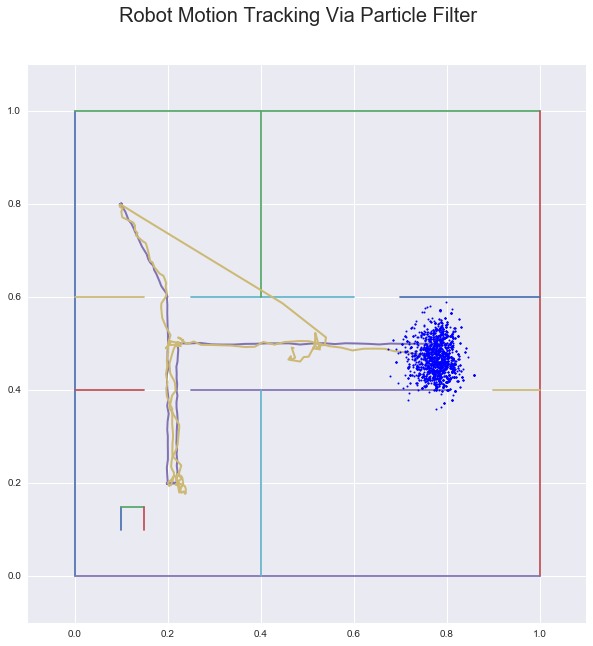

In [77]:
tmp = Partical_Filter(data, true_states)
tmp.build_model()
tmp.output_final_frame()

In [78]:
tmp.display_outcome()